In [4]:
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as cm

from matplotlib.colors import BASE_COLORS
from pathlib2 import Path
from string import Template

COLORS = list(BASE_COLORS.keys())

In [5]:
def plot_states(yout:np.ndarray, t:np.ndarray, states: list, title:str = '', xlim:list = None) -> None:
    with plt.rc_context({'figure.figsize': (14,10)}):
        fig, axes = plt.subplots(2, 2)
        axes = np.reshape(axes, 4)
        for i, state in enumerate(states):
                axes[i].plot(t, yout[:, i, 0], color = COLORS[i])
                
                axes[i].set_title(f'State: {state}')
                axes[i].set_xlabel(f'Time [s]')
                if xlim:
                        axes[i].set_xlim(xlim)
                axes[i].grid()
        fig.suptitle(title)
        plt.show()
        
labels = Template("${var} = ${beta}${unidade}")

# Características da Aeronave

Jato executivo: JetStar

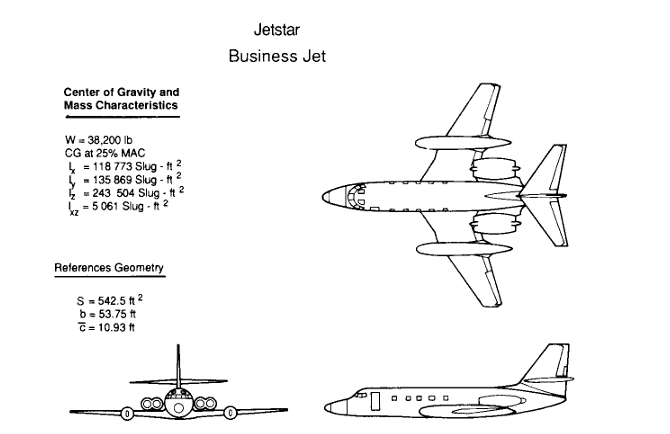

As derivadas de látero-direcionais de estabilidade para condição de cruzeiro de $M = 0.80$ e $H = 40,000 \ ft$ de altitude são apresentadas na tabela abaixo:

Coeficientes |$C_{y_\beta}$| $C_{l_\beta}$  |$C_{n_\beta}$|$C_{l_p}$| $C_{n_p}$|$C_{l_r}$|  
-------------|-------------|----------------|---------|----------|---------|------------|
Valores      | $-0.75$     | $-0.06$        | $0.13$  | $-0.42$  | $-0.756$| $0.04$     |
<b>Coeficientes</b> |$C_{n_r}$|$C_{l_{\delta a}}$| $C_{n_{\delta a}}$|$C_{y_{\delta r}}$| $C_{l_{\delta r}}$| $C_{n_{\delta r}}$|
Valores      | $-0.16$ | $0.060$          | $-0.06$           | $0.16$           | $0.029$           | $-0.057$          |

#### Definindo as propriedades da aeronave

In [6]:
# Fatores de conversão
ft_meters = 0.3048
slug_kg   = 14.5939  
lb_kg     = 0.453592

# Propriedades geométricas e de massa da aeronave
m   = 38200      * lb_kg                       # [kg]
Ix  = 118773    * slug_kg * ft_meters**2      # [kg m^2]
Iy  = 135869    * slug_kg * ft_meters**2      # [kg m^2]
Iz  = 243504    * slug_kg * ft_meters**2      # [kg m^2]
Ixz = 5061      * slug_kg * ft_meters**2      # [kg m^2]

S = 542.5 * ft_meters**2                    # [m^2]
b = 53.75 * ft_meters                       # [m]
c = 10.93 * ft_meters                       # [m]

print('Propriedades de massa:')
print(f'm   = {m}  kg')
print(f'Ix  = {Ix} kg m^2')
print(f'Iy  = {Iy} kg m^2')
print(f'Iz  = {Iz} kg m^2')
print(f'Ixz = {Ixz} kg m^2')

print('Propriedades Geométricas:')
print(f'S = {S} m^2')
print(f'b = {b} m')
print(f'c = {c} m')

# Coeficientes de estabilidade
Cy_beta = -0.75
Cl_beta = -0.06
Cn_beta =  0.13

Cl_p = -0.42
Cn_p = -0.756

Cl_r = 0.04
Cn_r = -0.16

Cl_delta_a = 0.060
Cn_delta_a = -0.06

Cy_delta_r = 0.16
Cl_delta_r = 0.029
Cn_delta_r = -0.057


Propriedades de massa:
m   = 17327.2144  kg
Ix  = 161034.5327669355 kg m^2
Iy  = 184213.59174653128 kg m^2
Iz  = 330147.02724423783 kg m^2
Ixz = 6861.793255482817 kg m^2
Propriedades Geométricas:
S = 50.3998992 m^2
b = 16.383 m
c = 3.331464 m


# Equação de Estados

A equação de estados para o movimento látero-direcional de uma aeronave em função das deflexões do aileron ($\Delta \delta_a$) e do rudder ($\Delta \delta_r$) é apresentada abaixo, onde $\theta_0$ é o ângulo de arfagem do avião que, para um vôo nivelavo, pode ser assumido igual a zero:

$$
\begin{bmatrix}
\Delta \dot{\beta}\\ 
\Delta \dot{p}\\ 
\Delta \dot{r}\\ 
\Delta \dot{\phi}
\end{bmatrix}

= 

\begin{bmatrix}
 \dfrac{Y_\beta}{u_0} & \dfrac{Y_p}{u_0}  & -\left(1- \dfrac{Y_r}{u_0}\right ) & \dfrac{gcos\theta_0}{u_0} \\ 
 L_\beta & L_p  & L_r  & 0 \\ 
 N_\beta & N_p  & N_r & 0 \\ 
 0 & 1 & 0  & 0 
\end{bmatrix}

\cdot

\begin{bmatrix}
\Delta \beta\\ 
\Delta p\\ 
\Delta r\\ 
\Delta \phi
\end{bmatrix}

+

\begin{bmatrix}
 0 & \dfrac{Y_{\delta_r}}{u_0}\\ 
 L_{\delta_a} & L_{\delta_r} \\ 
 N_{\delta_a} & N_{\delta_r} \\ 
0 & 0
\end{bmatrix}

\cdot

\begin{bmatrix}
\Delta \delta_a\\ 
\Delta \delta_r
\end{bmatrix}
$$

As derivadas laterais presente na equação de estados acima estão relacionadas com os coeficientes de estabilidade como apresentado abaixo, onde $Q = 0.5\rho u_0^2$ é a pressão dinâmica na altura de cruzeiro, $u_0 = c_0M$ a velocidade de cruzeiro da aeronave e $c_0$ a velocidade do som na altura de cruzeiro.

$$
\left\{\begin{matrix}
Y_{[\beta, \delta_r]}  & = & \dfrac{QSC_{y_{[\beta, \delta_r]}}}{m} & (ft/s^2) & Y_{[p,r]} & = & \dfrac{QSbC_{y_{[p,r]}}}{2mu_0} & (ft/s) \\
\ \\
L_{[\beta, \delta_r, \delta_a]} & = & \dfrac{QSbC_{l_{[\beta, \delta_r, \delta_a]}}}{I_x} & (1/s^2) & L_{[p, r]} & = & \dfrac{QSb^2C_{l_{[p,r]}}}{2I_x u_0} & (1/s) \\
\ \\
N_{[\beta, \delta_r, \delta_a]} & = &\dfrac{QSbC_{n_{[\beta, \delta_r, \delta_a]}}}{I_z} & (1/s^2) & N_{[p, r]} & = &\dfrac{QSb^2C_{n_{[p,r]}}}{2I_zu_0} & (1/s) \\
\end{matrix}\right.
$$

A densidade e a velocidade do som depende da temperatura do ambiente que por sua vez, depende da altura de cruzeiro como mostrado abaixo, onde $T_0 = 288.15 \ K$ e $\rho_0 = 1.225 \ kg/m^3$ são a temperatura e densidade do ar no nível do mar, $\lambda = -0.0065 \ K/m$ a constante da variação linear de temperatura da atmosfera, $R = 287.15 \ J/kgK$ a constante específica dos gases e $\gamma = 1.4$ a razão de calores específicos para o ar.
$$
\left\{\begin{matrix}
T = & T_0 + \lambda H & (K) \\
\ \\
\rho = & \rho_0\left(\frac{T}{T_0}\right)^{\frac{-g}{\lambda R} -1} & (kg/m^3) \\
\ \\
c = & \sqrt{\gamma R T} & (m/s)
\end{matrix}\right.
$$

#### Condições de cruzeiro

In [7]:
# Constantes
g       = 9.81              # [m/s^2]
T0      = 288.15            # [K]
Rsp     = 287.15
rho0    = 1.225             # [kg/m^3]
gamma   = 1.4
Lambda  = -0.0065

# Condição atmosférica de cruzeiro
M       = 0.8
H       = 40_000 * ft_meters

T   = T0 + Lambda*H
rho = rho0*(T/T0)**(-g/(Lambda*Rsp)  - 1)
c   = np.sqrt(gamma*Rsp*T)

# rho_slug = rho / slug_kg / (ft_meters**3)
# c_ft_s   = c/ft_meters

print('Unidade SI:')
print(f'rho = {rho} kg/m^3')
print(f'c = {c} m/s')

# print('\nUnidades Imperial:')
# print(f'rho = {rho_slug} slug/ft^3')
# print(f'c = {c_ft_s} ft/s')

# Condição de cruzeiro
u0 = c*M
Q  = 0.5*rho*u0**2
QS = Q*S

print('\nCondição de cruzeiro:')
# print(f'm  = {m} lb')
# print(f'u0 = {u0} ft/s')
# print(f'Q  = {Q} slug ft/s^2')
# print(f'QS = {QS} slug ft^3/s^2')
print(f'm  = {m} kg')
print(f'u0 = {u0} m/s')
print(f'Q  = {Q} kg m/s^4')
print(f'QS = {QS} kg m^3/s^4')

Unidade SI:
rho = 0.31166593379763347 kg/m^3
c = 289.7942253047841 m/s

Condição de cruzeiro:
m  = 17327.2144 kg
u0 = 231.8353802438273 m/s
Q  = 8375.654755536223 kg m/s^4
QS = 422132.1554130263 kg m^3/s^4


#### Sistema por Espaço de Estados

$$
\left\{\begin{matrix}
\dot{x} = A x + Bu \\
y = C x + Du 
\end{matrix}\right.
$$

Sys = <LinearIOSystem>: sys[8]
Inputs (2): ['u[0]', 'u[1]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-18.27178387   0.          -1.           0.04231451]
     [ -2.57676077  -0.63731753   0.06069691   0.        ]
     [  2.72318927  -0.55955141  -0.11842358   0.        ]
     [  0.           1.           0.           0.        ]]

B = [[ 0.          0.01681357]
     [ 2.57676077  1.24543437]
     [-1.25685659 -1.19401376]
     [ 0.          0.        ]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]]



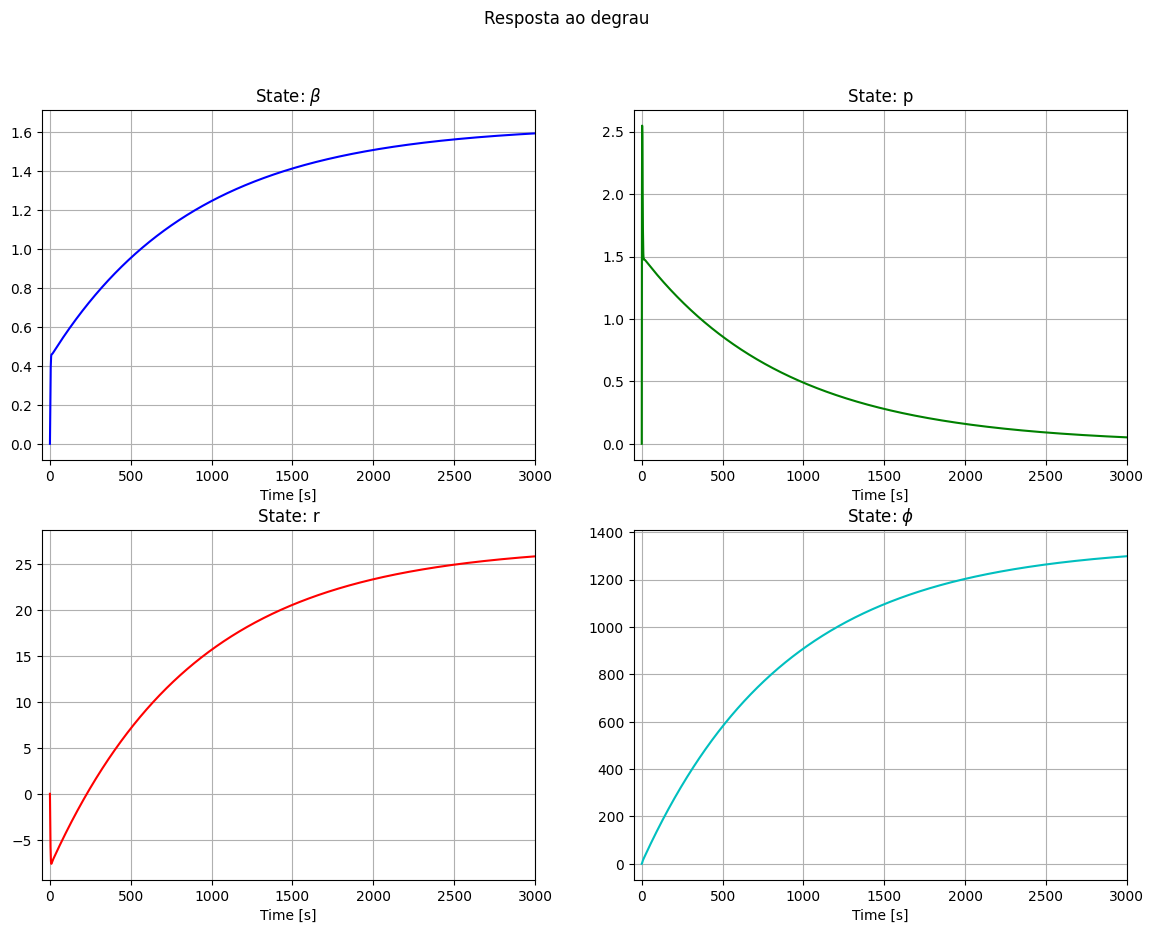

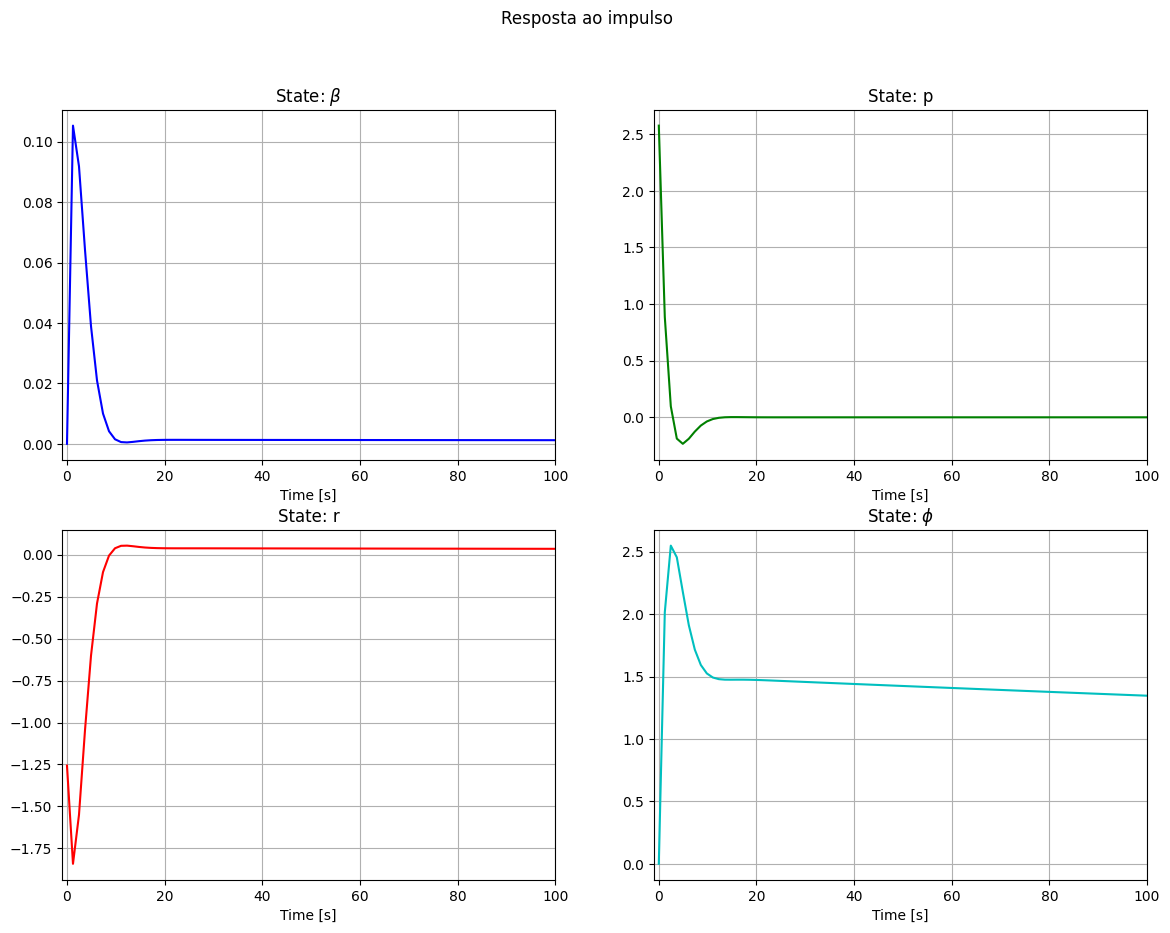

In [16]:

# Matriz A
A = np.empty((4,4))

A[0] =          np.array([QS*Cy_beta/m,          0,            -1,  g/u0])
A[1] = QS*b/Ix* np.array([Cl_beta     , b*Cl_p/(2*u0), b*Cl_r/(2*u0),  0])
A[2] = QS*b/Iz* np.array([Cn_beta     , b*Cn_p/(2*u0), b*Cn_r/(2*u0),  0])
A[3] =          np.array([0           ,             1,             0,  0])

# Matriz B
B = np.empty((4,2))

B[:, 0] = QS*b* np.array([0, Cl_delta_a/Ix, Cn_delta_a/Iz, 0])
B[:, 1] = QS*   np.array([Cy_delta_r/(u0*m), b*Cl_delta_r/Ix, b*Cn_delta_r/Iz, 0])

# Matriz C e D
C = np.diag(np.ones(4))
D = np.zeros((4, 2))

# Sistema por State-space
sys = cm.ss(A, B, C, D)
print(f'Sys = {sys}')

# Resposta ao degrau
yout, t = cm.step(sys)

states = [r'$\beta$', 'p', 'r', r'$\phi$']
plot_states(yout, t, states, title = 'Resposta ao degrau', xlim = [-50, 3000])

# Resposta ao degrau
yout, t = cm.impulse(sys)
plot_states(yout, t, states, title ='Resposta ao impulso', xlim = [-1, 100])


# Controle por realimentação estática de estados


Vamos realizar o controle apenas do ângulo de rolagem ($\beta$) considerando uma entrada do Aileron

Sys = <LinearIOSystem>: sys[15]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-18.27178387   0.          -1.           0.04231451]
     [ -2.57676077  -0.63731753   0.06069691   0.        ]
     [  2.72318927  -0.55955141  -0.11842358   0.        ]
     [  0.           1.           0.           0.        ]]

B = [[ 0.        ]
     [ 2.57676077]
     [-1.25685659]
     [ 0.        ]]

C = [[1. 0. 0. 0.]]

D = [[0.]]



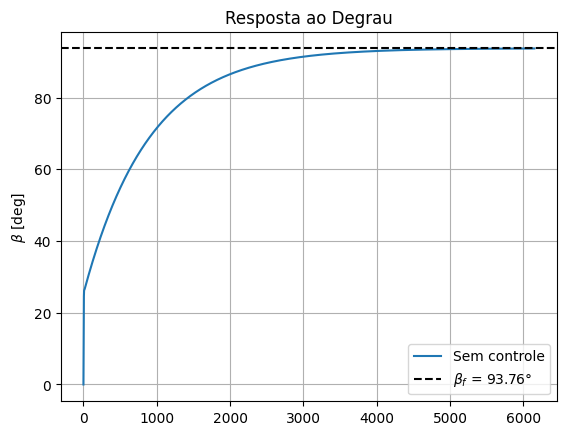

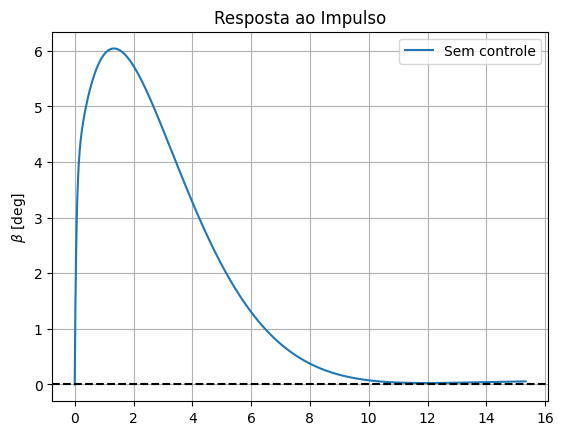

In [25]:
C = np.array([1,0,0,0])
# C = np.diag(np.ones(4))
D = np.zeros((1,1))
B_mod = np.reshape(B[:,0].copy(), (4,1))

# Sistema por State-space
sys_lat_dir = cm.ss(A,B_mod, C, D)
# sys_lat_dir = cm.ss(A,B, C, D)
print(f'Sys = {sys_lat_dir}')

#Resposta ao Degrau
yout, t = cm.step(sys_lat_dir)
info = cm.stepinfo(sys_lat_dir)
ssvalue = np.rad2deg(info['SteadyStateValue'])
plt.plot(t, np.rad2deg(yout), label =  'Sem controle')
plt.axhline(y = ssvalue, color = 'k', linestyle = '--', 
            label = labels.substitute(
                var = r"$\beta_f$",
                beta = np.round(ssvalue,2),
                unidade = '°'   
            )
            )

# plt.xlim([-50,3000])
plt.ylabel(r'$\beta$ [deg]')
plt.title('Resposta ao Degrau')

plt.legend()
plt.grid()
plt.show()

#Resposta ao Impulso
yout, t = cm.impulse(sys_lat_dir)

plt.plot(t, np.rad2deg(yout), label =  'Sem controle')
plt.axhline(0, color = 'k', linestyle ='--')

plt.ylabel(r'$\beta$ [deg]')
plt.title('Resposta ao Impulso')

plt.legend()
plt.grid()
plt.show()

#### Lugar das Raízes

[-1.81254945e+01+0.j         -4.50453462e-01+0.29613321j
 -4.50453462e-01-0.29613321j -1.12355092e-03+0.j        ]


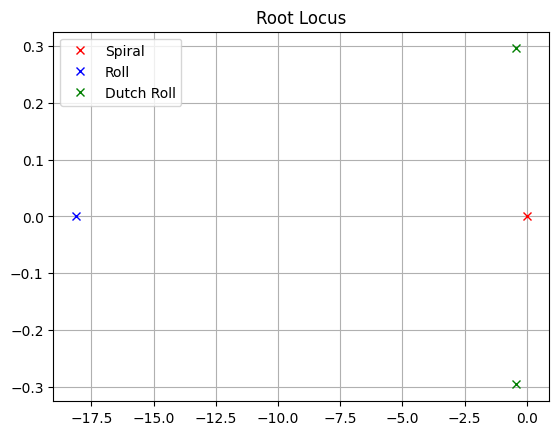

In [18]:
poles = cm.poles(sys_lat_dir)
print(poles)

plt.plot(poles[3].real, poles[3].imag,'rx', label = 'Spiral') 
plt.plot(poles[0].real, poles[0].imag,'bx', label = 'Roll') 
plt.plot(poles[1:3].real, poles[1:3].imag,'gx', label = 'Dutch Roll') 

plt.title('Root Locus')

# plt.xlim([-0.5, 0.2])
# plt.ylim([-400, 400])

plt.legend()
plt.grid()
plt.show()


#### Controlabilidade e Observabilidade

O sistema é tanto obeservável quanto controlável, como mostrado a seguir

In [19]:
co = cm.ctrb(sys_lat_dir.A, sys_lat_dir.B)
Controllability = np.linalg.matrix_rank(co)
print(f'Controllability = {Controllability}')

ob = cm.obsv(sys_lat_dir.A,sys_lat_dir.C)
Observability = np.linalg.matrix_rank(ob)
print(f'Observability = {Observability}')

Controllability = 4
Observability = 4


#### Requisitos de controle
Para um avião Classe II, Categoria B, queremos realizar o controle de modo que a aeronave seja classificada como Nível 1 na qualidade de voo, assim os requisitos para cada modo são estabelicidos abaixo:

- Rolagem: $\tau \leq 1.4 \ s$
- Espiral - Tempo para dobrar de amplitude:  $t = 20 s$
- Rolagem Holandesa: $\zeta\omega_n \geq 0.15 \ rad/s, \ \omega_n \geq 0.4 \ rad/s , \zeta \geq 0.08$

A planta já atinge o requisito para o modo espiral apesar de ser instável. É comum na aviação permitir esse tipo de configuração tendo em vista que é um modo mais lento e que o piloto pode agir sobre ele.

##### Sistema em malha aberta

#### Alocação de polos pela fórmula de Ackermann

roll pole = -8.695652173913043
wn = 2.17
zeta = 0.215
dutch roll poles = [-0.46655+2.11925249j -0.46655-2.11925249j]
[[ 1.47012841e+02 -1.23672772e-01  7.21747233e+00 -2.79449390e-01]]
Sys = <LinearIOSystem>: sys[25]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-1.82717839e+01  0.00000000e+00 -1.00000000e+00  4.23145078e-02]
     [-3.81393683e+02 -3.18642378e-01 -1.85370026e+01  7.20074223e-01]
     [ 1.87497248e+02 -7.14990346e-01  8.95290407e+00 -3.51227806e-01]
     [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[ 0.        ]
     [ 2.57676077]
     [-1.25685659]
     [ 0.        ]]

C = [[1. 0. 0. 0.]]

D = [[0.]]



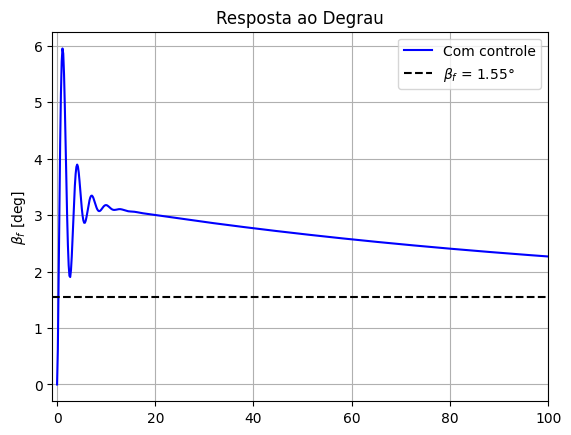

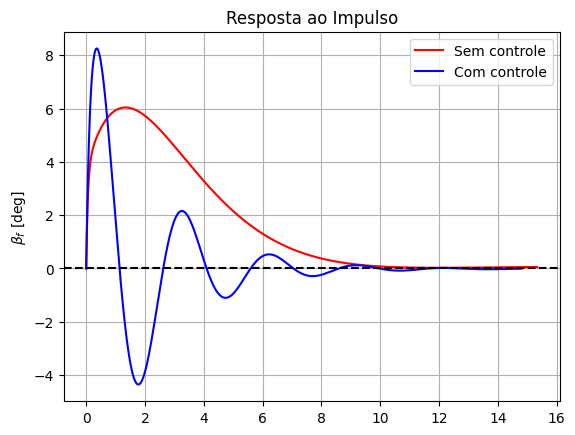

In [35]:
# Polínomio de alocação de polos
zetawn_min = 0.15
zeta_min   = 0.08
wn_min     = 0.4
zeta = 0.215
wn = 2.17


wn = wn if wn >= 0.4 else 0.4 

if wn*zeta < zetawn_min:
    wn = zetawn_min/(zeta)
    print(f'Correção da freq: {wn}')

roll_time = 0.115
roll_time = roll_time if roll_time< 1.4 else 1.4
roll_pole = -1/roll_time
print(rf'roll pole = {roll_pole}')
print(f'wn = {wn}')
print(f'zeta = {zeta}')

# Projeto sem rastreamento
dutch_roll_poles = np.poly1d([1, 2*zeta*wn, wn**2]).roots
print(f'dutch roll poles = {dutch_roll_poles}')
spiral_pole = -0.00877
poles_place = np.concatenate(([spiral_pole, roll_pole], dutch_roll_poles))
# poles_place = np.array([-0.00877,-8.435, -0.487+2.335j , -0.487-2.335j  ])
K = cm.place(sys_lat_dir.A,sys_lat_dir.B,poles_place)
print(K)
sys_lat_dir_with_control = cm.ss(sys_lat_dir.A - sys_lat_dir.B @ K, sys_lat_dir.B, sys_lat_dir.C, sys_lat_dir.D)

print(f'Sys = {sys_lat_dir_with_control}')

#Resposta ao Degrau
yout, t = cm.step(sys_lat_dir_with_control)
info = cm.stepinfo(sys_lat_dir_with_control)
ssvalue = np.rad2deg(info['SteadyStateValue'])

plt.plot(t, np.rad2deg(yout), 'b', label = 'Com controle')
plt.axhline(ssvalue, color = 'k', linestyle = '--', 
            label = labels.substitute(
                var = r"$\beta_f$",
                beta = np.round(ssvalue,2),
                unidade = '°'
            ))

plt.xlim([-1,100])

plt.ylabel(r'$\beta_f$ [deg]')
plt.title('Resposta ao Degrau')
plt.legend()
plt.grid()
plt.show()

#Resposta ao Degrau
yout_with_control, t_wc = cm.impulse(sys_lat_dir_with_control)
yout,t = cm.impulse(sys_lat_dir)

plt.plot(t, np.rad2deg(yout), 'r', label = 'Sem controle')
plt.plot(t_wc, np.rad2deg(yout_with_control), 'b', label = 'Com controle')
plt.axhline(0, color = 'k', linestyle = '--')

# plt.xlim([-1,100])

plt.ylabel(r'$\beta_f$ [deg]')
plt.title('Resposta ao Impulso')
plt.legend()
plt.grid()
plt.show()
